In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import os
import datetime
import time
import lpips
from pytorch_msssim import ssim  # 添加SSIM导入
#start_time = datetime.datetime.now()
#print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
device = torch.device("cuda:2")
print(torch.cuda.is_available())

True


In [3]:
#load data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
test_set = datasets.MNIST(
    root='./mnistdata',
    train=False,
    transform=transform,
    download=True
)
test_loader = DataLoader(
    test_set, batch_size=128, shuffle=False, num_workers=1, drop_last=True
)
real_labels = np.array([label for _, label in test_set])

In [4]:
# state_dict
model_path_hmvae = './saved_models_hmvae_mnist/model_epoch_496_loss_21.7908.pt'
state_dict = torch.load(model_path_hmvae, map_location=device)
model_path_MEMvae = './saved_models_MEMvae_mnist/model_epoch_498_loss_22.3760.pt'
state_dict_MEMvae = torch.load(model_path_MEMvae, map_location=device)
model_path_vae = './saved_models_vae_mnist/model_epoch_492_loss_23.7127.pt'
state_dict_vae = torch.load(model_path_vae, map_location=device)
model_path_cnn="./saved_models_cnn_mnist/model_epoch_27_acc_99.3590.pt"
state_dict_cnn=torch.load(model_path_cnn, map_location=device)

In [ ]:
from HMVAE import HMVAE
n_levels = 3
n_regions=2
region_slot_config= [
    ( [50, 50, 50], [64, 128, 256] ),  
    ( [64, 64,64],   [32,64, 128] )      
]
latent_dim = 20
hidden_dim =128
image_channels = 1  # MNIST has 1 channel
image_size = 28  # 28x28 images
model_hmvae = HMVAE( n_levels, n_regions, region_slot_config,latent_dim,hidden_dim,image_channels,image_size).to(device)
model_hmvae.load_state_dict(state_dict)
model_hmvae.to(device)

HMVAE(
  (encoder): Encoder(
    (linears): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (latent): Linear(in_features=128, out_features=20, bias=True)
    (get_mu): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=20, bias=True)
    )
    (get_logvar): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=20,

In [7]:
#Loading 1-layers
from MEMVAE import MEMVAE
n_levels = 1
num_slots_list = [50]  # Just example sizes
slot_dim_list = [64]  # Example embedding sizes
latent_dim = 20
hidden_dim =128
image_channels = 1  # MNIST has 1 channel
image_size = 28  # 28x28 images
model_MEMvae_1layers= MEMVAE( n_levels, num_slots_list, slot_dim_list,latent_dim,hidden_dim,image_channels,image_size).to(device)
model_MEMvae_1layers.load_state_dict(state_dict_MEMvae)
model_MEMvae_1layers.to(device)

MEMVAE(
  (encoder): Encoder(
    (linears): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (latent): Linear(in_features=128, out_features=20, bias=True)
    (get_mu): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=20, bias=True)
    )
    (get_logvar): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=20

In [8]:
from VAE import VAE
model_vae  = VAE(latent_dim=20,hidden_dim=128,image_channels=1,image_size=28).to(device)
model_vae.load_state_dict(state_dict_vae)

<All keys matched successfully>

In [ ]:
def add_salt_and_pepper_noise(images, salt_prob=0.05, pepper_prob=0.05):
    """
        Add salt-and-pepper noise to input images
    
    Args:
        images (torch.Tensor): Input image tensor with shape [batch_size, channels, height, width]
        salt_prob (float, optional): Probability of adding salt noise. Default: 0.05
        pepper_prob (float, optional): Probability of adding pepper noise. Default: 0.05
    
    Returns:
        torch.Tensor: Noisy image tensor with same shape as input
    """
 
    if not torch.is_tensor(images):
        raise TypeError("Input images should  be a tensor")

   
    noise = torch.rand(images.shape[0], 1, images.shape[2], images.shape[3], device=images.device)

    
    salt_mask = (noise < salt_prob).float()  
    images_with_salt = torch.where(salt_mask.expand_as(images) == 1, torch.ones_like(images), images)

    pepper_mask = (noise > (1 - pepper_prob)).float() 
    images_with_salt_and_pepper = torch.where(pepper_mask.expand_as(images) == 1, torch.zeros_like(images_with_salt), images_with_salt)

    return images_with_salt_and_pepper

In [ ]:
def add_gaussian_noise(images, mean=0.0, std=0.3):
    """
    Add Gaussian noise to input images
    Args:
        images (torch.Tensor): Input image tensor with shape [batch_size, channels, height, width]
        mean (float, optional): Mean of the Gaussian noise. Default: 0.0
        std (float, optional): Standard deviation of the Gaussian noise. Default: 0.1
    Returns:
        torch.Tensor: Noisy image tensor with same shape as input
    """
    if not torch.is_tensor(images):
        raise TypeError("Input images should be a tensor")
    
    noise = torch.randn_like(images) * std + mean
    noisy_images = torch.clamp(images + noise, -1.0, 1.0)
    
    return noisy_images

In [ ]:
def add_dynamic_mask_noise(images, max_num_masks=5, max_mask_ratio=0.3):
    """
    Add dynamic rectangle masking noise (automatically adapts to image dimensions)
    
    Args:
        images (torch.Tensor): Input image tensor with shape [batch_size, channels, height, width]
        max_num_masks (int, optional): Maximum number of masks per image. Default: 5
        max_mask_ratio (float, optional): Maximum area ratio (0-1) for each mask relative to image size. Default: 0.3
    
    Returns:
        torch.Tensor: Noisy image tensor with same shape as input
    """
    if not torch.is_tensor(images):
        raise TypeError("Input images should be a tensor")
    
    device = images.device
    noisy_images = images.clone()
    b, c, h, w = images.shape
    
    for bidx in range(b):
        num_masks = torch.randint(1, max_num_masks+1, (1,)).item()
        
        for _ in range(num_masks):
            max_dim = int(min(h, w) * max_mask_ratio)
            mask_h = torch.randint(1, max_dim+1, (1,), device=device)
            mask_w = torch.randint(1, max_dim+1, (1,), device=device)
            
            x = torch.randint(0, w - mask_w + 1, (1,), device=device)
            y = torch.randint(0, h - mask_h + 1, (1,), device=device)
            
            noise_value = torch.rand(1, device=device)
            noisy_images[bidx, :, y:y+mask_h, x:x+mask_w] = noise_value
    
    return noisy_images

In [ ]:
def plot_combined_comparison(samples_dict, save_dir=None, figsize=(24, 12)):
    plt.figure(figsize=figsize)
    num_models = len(samples_dict)
    
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081

    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(save_dir, f"denoising_comparison_{timestamp}.png")
    else:
        save_path = None

    ref_samples = next(iter(samples_dict.values()))[1]
    original = ref_samples[0]  # [64, 1, 28, 28]
    noisy = ref_samples[1]     

    def prepare_grid(tensor, denorm=False):
        if denorm:
            tensor = denormalize(tensor)
        grid = torchvision.utils.make_grid(tensor.cpu(), nrow=8, padding=2, normalize=False)
        return grid.permute(1, 2, 0).numpy()  # CHW -> HWC

   
    plt.subplot(2, num_models+2, 1)
    orig_grid = prepare_grid(original)
    plt.imshow(orig_grid, cmap='gray')
    plt.title("Original Images")
    plt.axis('off')

    
    plt.subplot(2, num_models+2, 2)
    noisy_grid = prepare_grid(noisy, denorm=True)
    plt.imshow(noisy_grid, cmap='gray')
    plt.title("Noisy Inputs")
    plt.axis('off')

   
    for idx, (model_name, (mse, samples)) in enumerate(samples_dict.items()):
        gen_images = samples[2]  
        
        plt.subplot(2, num_models+2, idx+3)
        gen_grid = prepare_grid(gen_images)
        plt.imshow(gen_grid, cmap='gray')
        plt.title(f"{model_name}")
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"对比图已保存至：{save_path}")
    plt.show()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0111 | LPIPS: 0.0793 | SSIM: 0.7968 | PSNR: 19.87 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0107 | LPIPS: 0.0733 | SSIM: 0.8165 | PSNR: 20.07 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0104 | LPIPS: 0.0729 | SSIM: 0.8210 | PSNR: 20.24 dB
对比图已保存至：./gaussian0.1_noise_results\denoising_comparison_20250326_192511.png


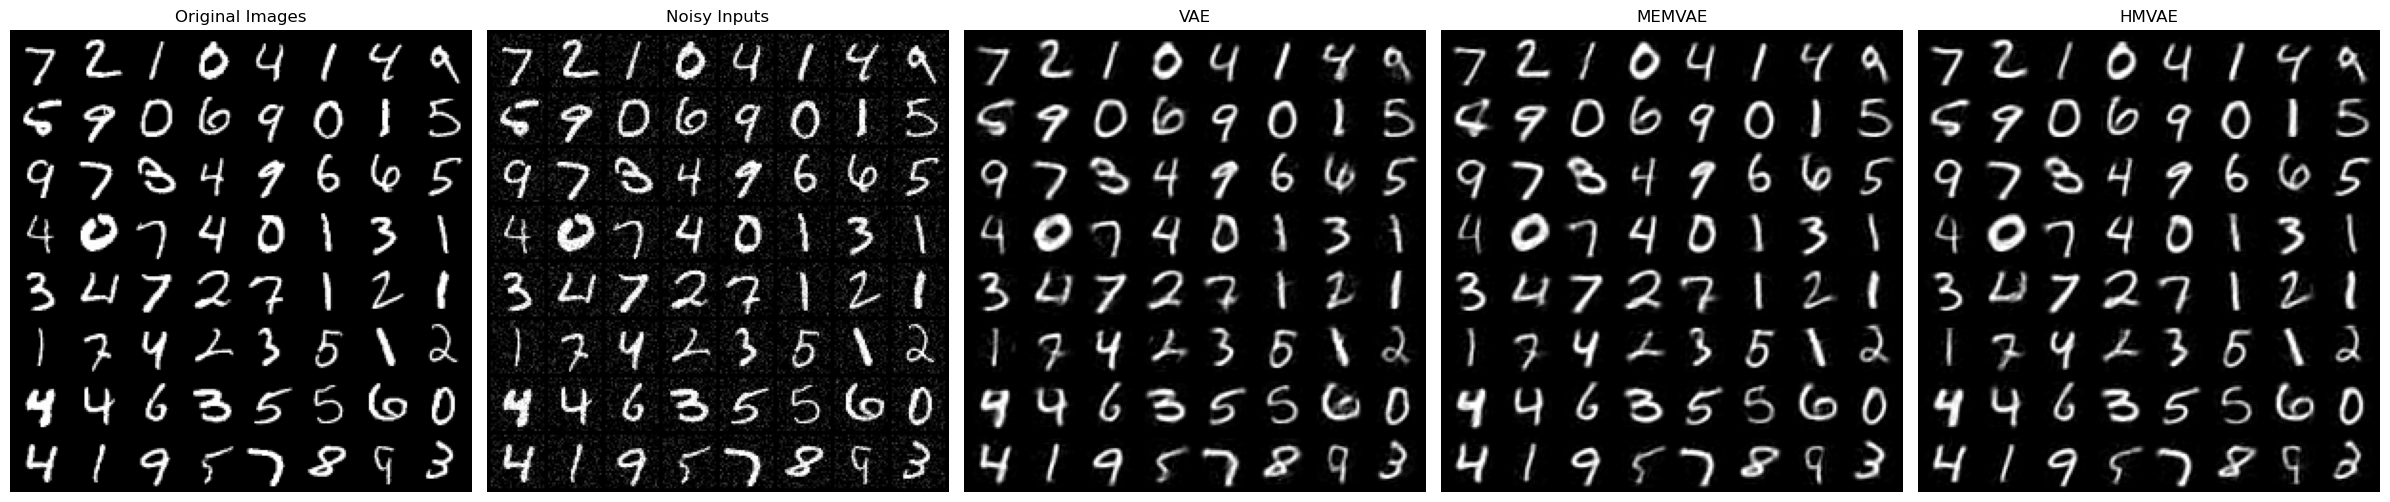

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True,
                          mean=0.0, std=0.1, save_samples=False):
    """
    Evaluate generative model and save sample comparisons
    
    Args:
        save_samples (bool): Flag to enable saving comparison samples
    
    Returns:
        float: Mean Squared Error (MSE) between generated and original images
        tuple: When enabled, returns tuple containing:
            - original_images (torch.Tensor): Ground truth images [batch_size, channels, height, width]
            - noisy_inputs (torch.Tensor): Noisy input samples [batch_size, channels, height, width]
            - generated_images (torch.Tensor): Model outputs [batch_size, channels, height, width]
            Only returned if save_samples=True
    """
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none')  
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0  
    total_samples = 0
    total_psnr = 0.0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
            
            clean_images = denormalize(images.to(device))
            
          
            if add_noise:
                noisy_images =inputs = add_gaussian_noise(clean_images, mean, std)
                inputs = normalize(noisy_images)  
            else:
                inputs = normalize(clean_images)  

           
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data)  
            gen_data = gen_data.view(-1, 1, 28, 28)
           
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1)  
            gen_rgb = gen_data.repeat(1,3,1,1)
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
             
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True 
            )
           
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            total_psnr += batch_psnr * images.size(0)
            
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples  
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips,avg_ssim ,avg_psnr, samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./gaussian0.1_noise_results",
    figsize=(24, 12)
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0171 | LPIPS: 0.0998 | SSIM: 0.7191 | PSNR: 17.91 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0173 | LPIPS: 0.0941 | SSIM: 0.7324 | PSNR: 17.92 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0161 | LPIPS: 0.0890 | SSIM: 0.7512 | PSNR: 18.28 dB
对比图已保存至：./gaussian0.2_noise_results\denoising_comparison_20250326_192555.png


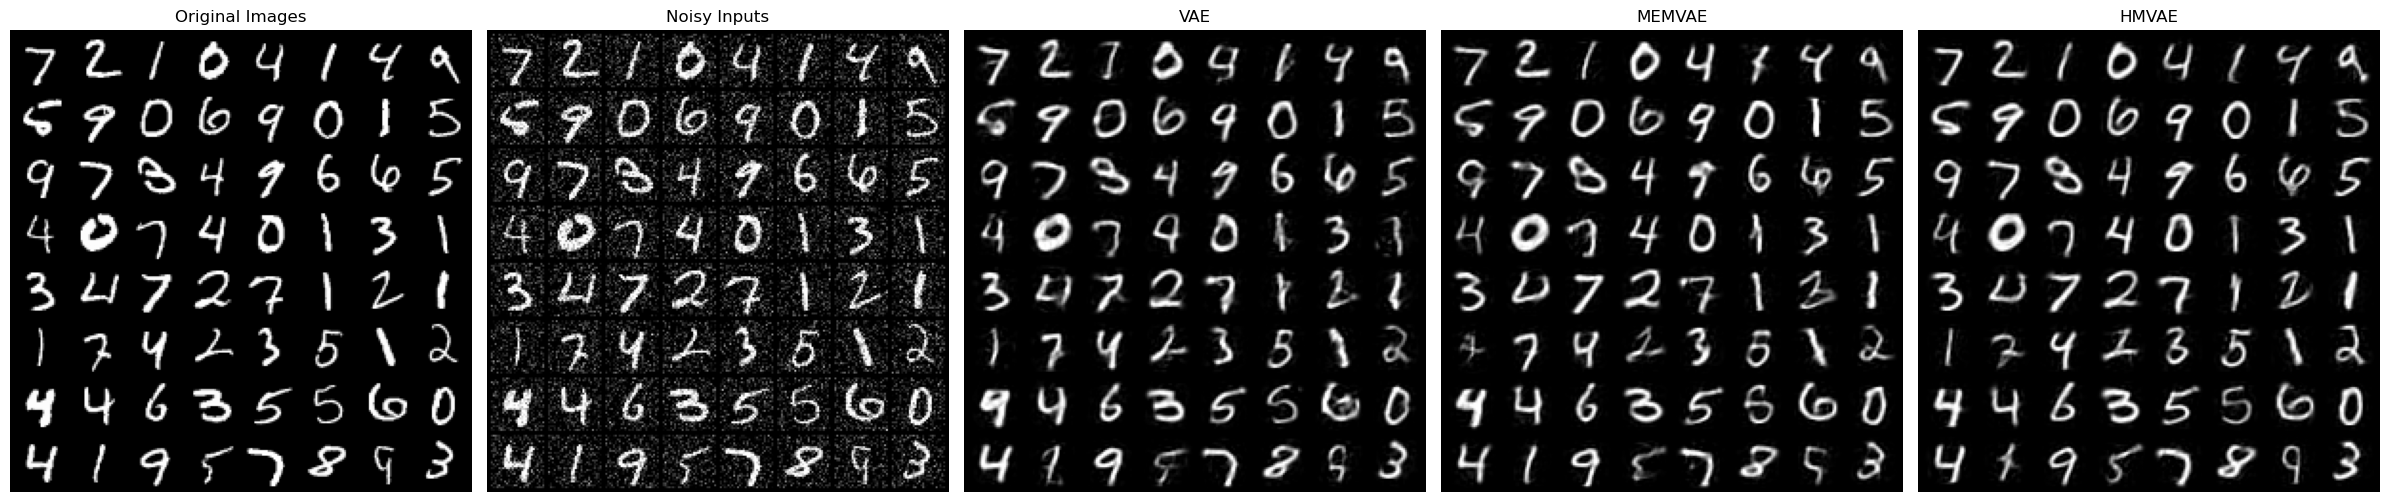

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True,
                          mean=0.0, std=0.2, save_samples=False):
    """
    Evaluate generative model and save sample comparisons
    
    Args:
        save_samples (bool): Flag to enable saving comparison samples
    
    Returns:
        float: Mean Squared Error (MSE) between generated and original images
        tuple: When enabled, returns tuple containing:
            - original_images (torch.Tensor): Ground truth images [batch_size, channels, height, width]
            - noisy_inputs (torch.Tensor): Noisy input samples [batch_size, channels, height, width]
            - generated_images (torch.Tensor): Model outputs [batch_size, channels, height, width]
            Only returned if save_samples=True
    """

    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none')  
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0 
    total_samples = 0
    total_psnr = 0.0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
           
            clean_images = denormalize(images.to(device))
            
          
            if add_noise:
                noisy_images =inputs = add_gaussian_noise(clean_images, mean, std)
                inputs = normalize(noisy_images) 
            else:
                inputs = normalize(clean_images) 

           
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data) 
            gen_data = gen_data.view(-1, 1, 28, 28)
           
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1)  
            gen_rgb = gen_data.repeat(1,3,1,1)
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
            
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True  
            )
            
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            total_psnr += batch_psnr * images.size(0)
            
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples  
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips,avg_ssim ,avg_psnr, samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./gaussian0.2_noise_results",
    figsize=(24, 12)
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0261 | LPIPS: 0.1270 | SSIM: 0.6211 | PSNR: 16.04 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0275 | LPIPS: 0.1228 | SSIM: 0.6224 | PSNR: 15.91 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0258 | LPIPS: 0.1151 | SSIM: 0.6453 | PSNR: 16.26 dB
对比图已保存至：./gaussian0.3_noise_results\denoising_comparison_20250326_192638.png


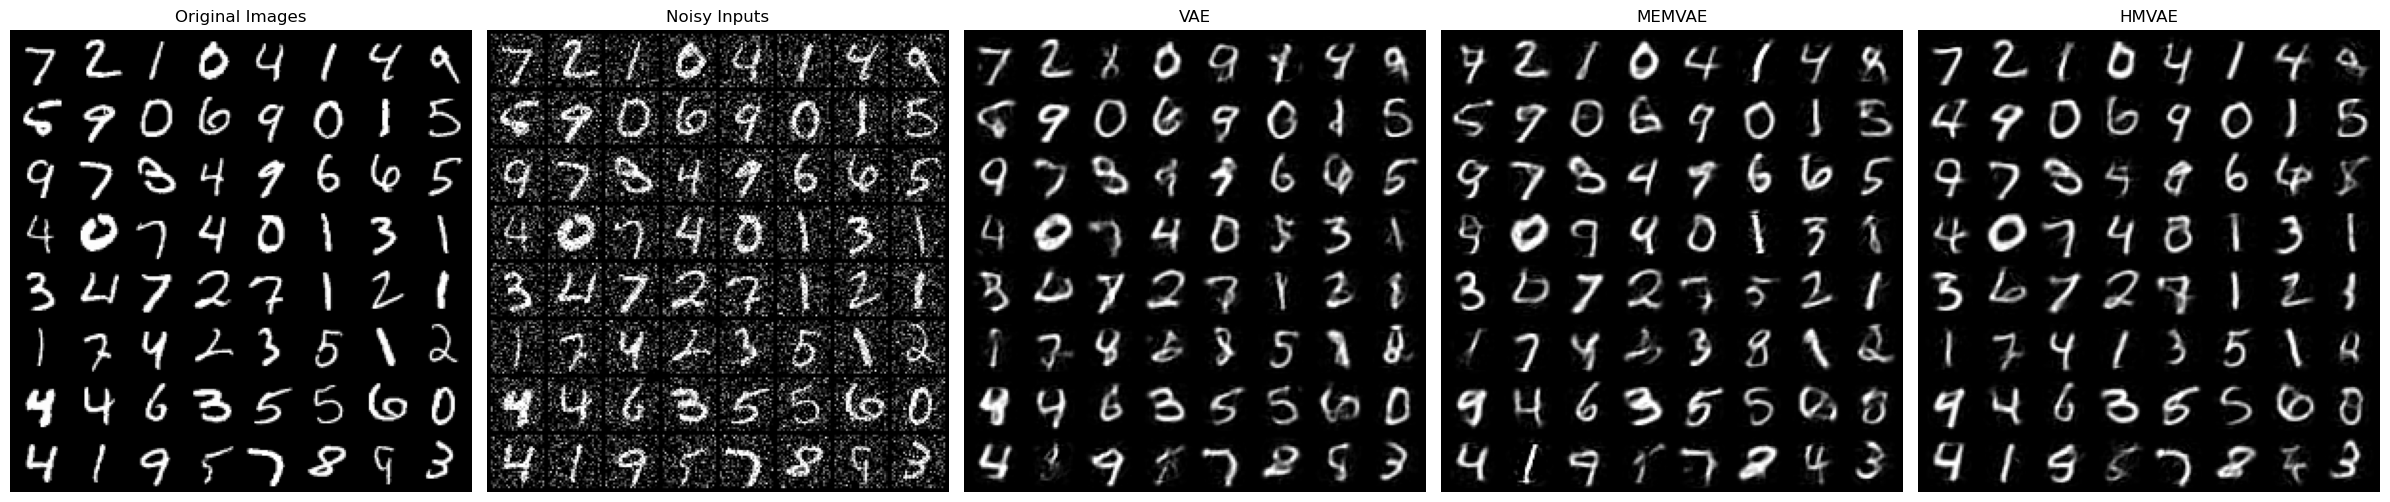

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True,
                          mean=0.0, std=0.3, save_samples=False):
    """
    Evaluate generative model and save sample comparisons
    
    Args:
        save_samples (bool): Flag to enable saving comparison samples
    
    Returns:
        float: Mean Squared Error (MSE) between generated and original images
        tuple: When enabled, returns tuple containing:
            - original_images (torch.Tensor): Ground truth images [batch_size, channels, height, width]
            - noisy_inputs (torch.Tensor): Noisy input samples [batch_size, channels, height, width]
            - generated_images (torch.Tensor): Model outputs [batch_size, channels, height, width]
            Only returned if save_samples=True
    """
 
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none') 
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0 
    total_samples = 0
    total_psnr = 0.0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
            
            clean_images = denormalize(images.to(device))
            
            
            if add_noise:
                noisy_images =inputs = add_gaussian_noise(clean_images, mean, std)
                inputs = normalize(noisy_images)  
            else:
                inputs = normalize(clean_images) 

           
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data) 
            gen_data = gen_data.view(-1, 1, 28, 28)
           
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1)  
            gen_rgb = gen_data.repeat(1,3,1,1)
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
             
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True  
            )
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            total_psnr += batch_psnr * images.size(0)
           
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples  
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips,avg_ssim ,avg_psnr, samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./gaussian0.3_noise_results",
    figsize=(24, 12)
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0362 | LPIPS: 0.1532 | SSIM: 0.5271 | PSNR: 14.61 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0390 | LPIPS: 0.1520 | SSIM: 0.5169 | PSNR: 14.38 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0377 | LPIPS: 0.1443 | SSIM: 0.5308 | PSNR: 14.62 dB
对比图已保存至：./gaussian0.4_noise_results\denoising_comparison_20250326_215911.png


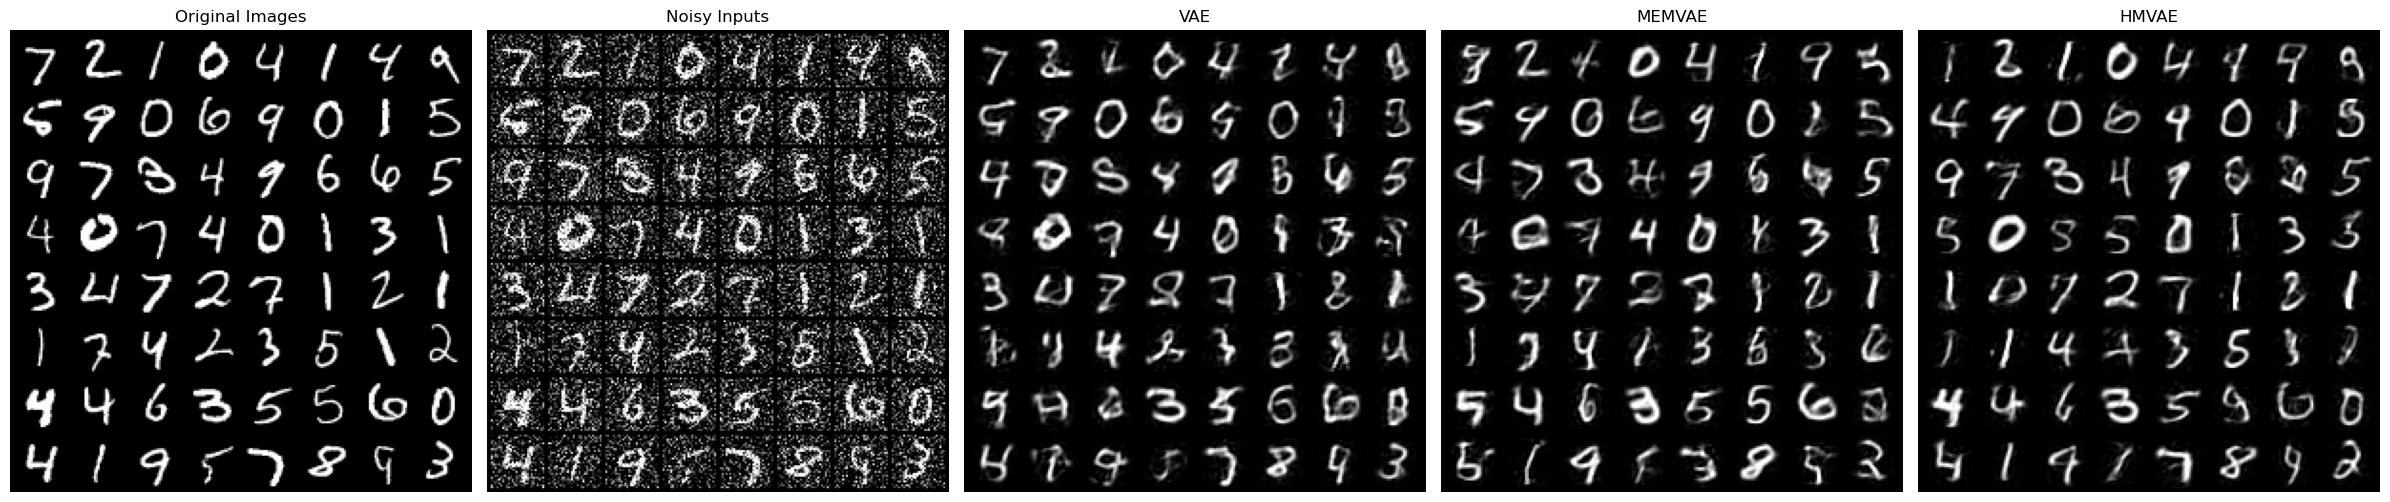

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True,
                          mean=0.0, std=0.4, save_samples=False):
    """
    Evaluate generative model and save sample comparisons
    
    Args:
        save_samples (bool): Flag to enable saving comparison samples
    
    Returns:
        float: Mean Squared Error (MSE) between generated and original images
        tuple: When enabled, returns tuple containing:
            - original_images (torch.Tensor): Ground truth images [batch_size, channels, height, width]
            - noisy_inputs (torch.Tensor): Noisy input samples [batch_size, channels, height, width]
            - generated_images (torch.Tensor): Model outputs [batch_size, channels, height, width]
            Only returned if save_samples=True
    """
    
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none') 
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0 
    total_samples = 0
    total_psnr = 0.0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
           
            clean_images = denormalize(images.to(device))
            
            
            if add_noise:
                noisy_images =inputs = add_gaussian_noise(clean_images, mean, std)
                inputs = normalize(noisy_images)  
            else:
                inputs = normalize(clean_images)  

            
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data)  
            gen_data = gen_data.view(-1, 1, 28, 28)
           
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1) 
            gen_rgb = gen_data.repeat(1,3,1,1)
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
            
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True  
            )
           
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            total_psnr += batch_psnr * images.size(0)
            
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples  
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips,avg_ssim ,avg_psnr, samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./gaussian0.4_noise_results",
    figsize=(24, 12)
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0462 | LPIPS: 0.1764 | SSIM: 0.4449 | PSNR: 13.55 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0500 | LPIPS: 0.1796 | SSIM: 0.4273 | PSNR: 13.27 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0505 | LPIPS: 0.1746 | SSIM: 0.4222 | PSNR: 13.36 dB
对比图已保存至：./gaussian0.5_noise_results\denoising_comparison_20250326_215950.png


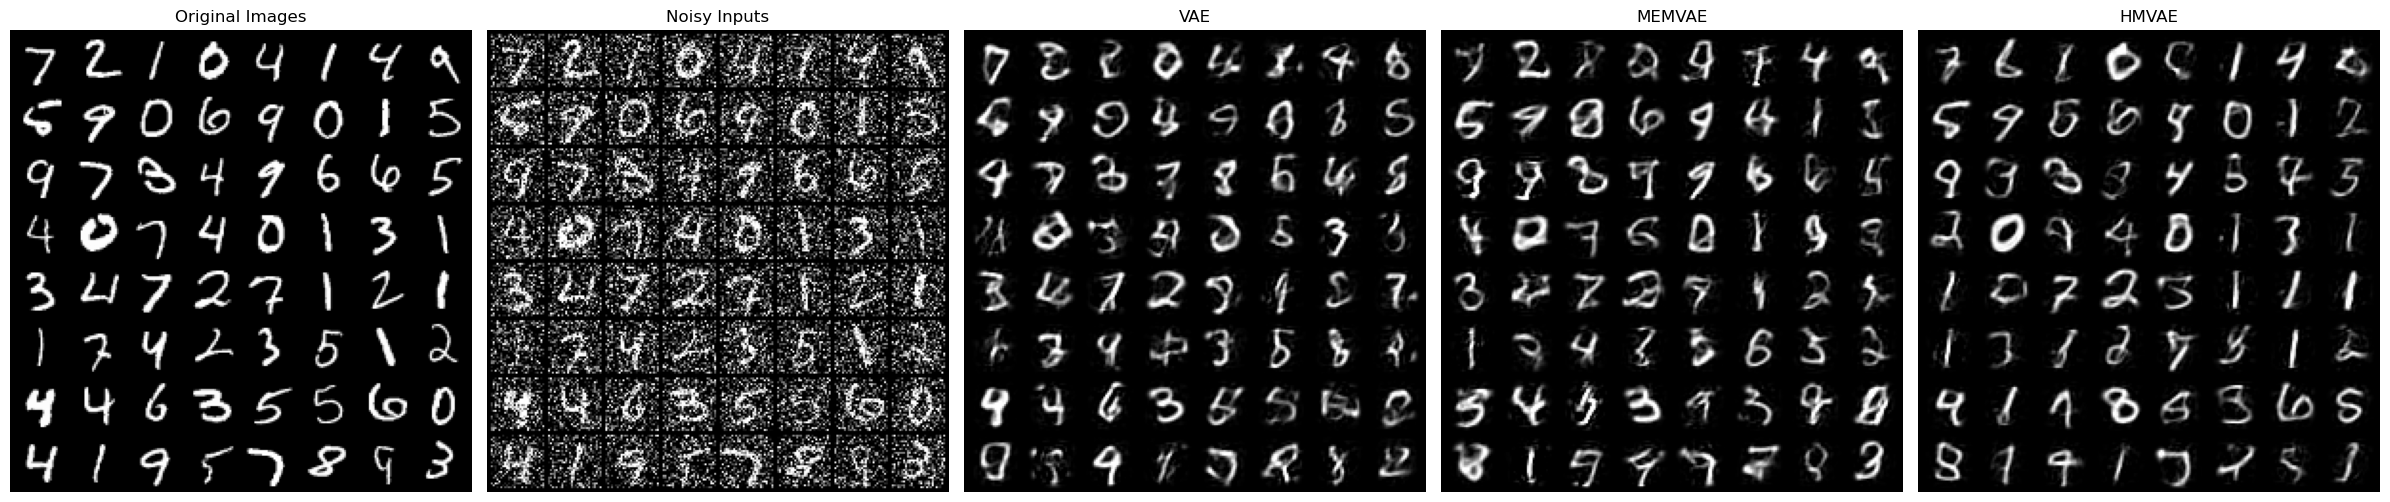

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True,
                          mean=0.0, std=0.5, save_samples=False):
    """
    Evaluate generative model and save sample comparisons
    
    Args:
        save_samples (bool): Flag to enable saving comparison samples
    
    Returns:
        float: Mean Squared Error (MSE) between generated and original images
        tuple: When enabled, returns tuple containing:
            - original_images (torch.Tensor): Ground truth images [batch_size, channels, height, width]
            - noisy_inputs (torch.Tensor): Noisy input samples [batch_size, channels, height, width]
            - generated_images (torch.Tensor): Model outputs [batch_size, channels, height, width]
            Only returned if save_samples=True
    """
   
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none')  
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0
    total_samples = 0
    total_psnr = 0.0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
           
            clean_images = denormalize(images.to(device))
            
            
            if add_noise:
                noisy_images =inputs = add_gaussian_noise(clean_images, mean, std)
                inputs = normalize(noisy_images)  
            else:
                inputs = normalize(clean_images) 

           
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data)  
            gen_data = gen_data.view(-1, 1, 28, 28)
           
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1) 
            gen_rgb = gen_data.repeat(1,3,1,1)
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
             
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True  
            )
            
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            total_psnr += batch_psnr * images.size(0)
            
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples  
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips,avg_ssim ,avg_psnr, samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./gaussian0.5_noise_results",
    figsize=(24, 12)
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0237 | LPIPS: 0.1250 | SSIM: 0.6344 | PSNR: 16.50 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0245 | LPIPS: 0.1201 | SSIM: 0.6412 | PSNR: 16.45 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0224 | LPIPS: 0.1115 | SSIM: 0.6666 | PSNR: 16.88 dB
对比图已保存至：./salt_and_pepper_noise_results\denoising_comparison_20250326_192720.png


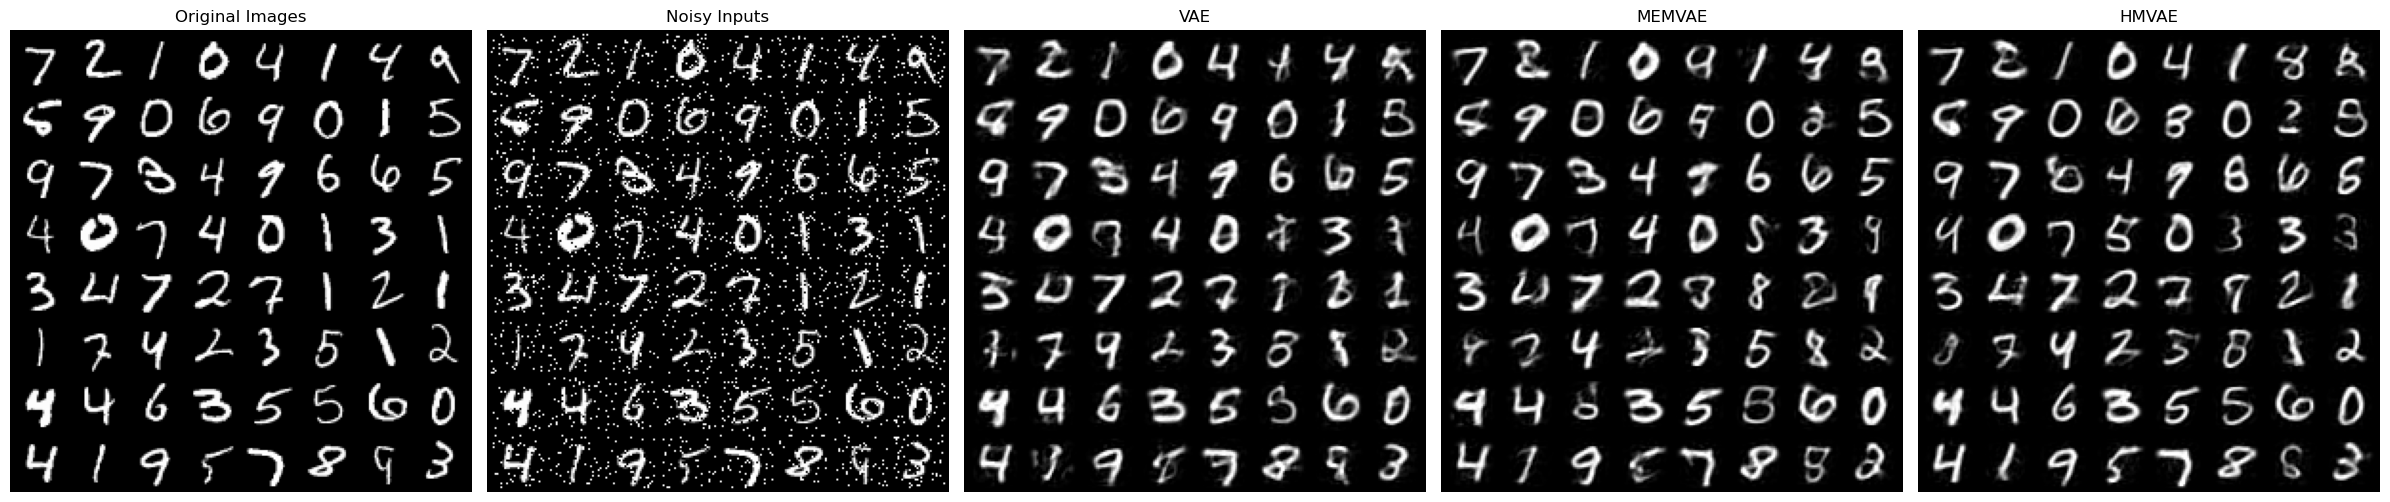

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True, salt_prob=0.05, pepper_prob=0.05,save_samples=False):
    """
    Evaluate generator model's MSE with and without noisy inputs
    
    Args:
        generator (nn.Module): Pre-trained generator model
        test_loader (DataLoader): Test dataloader containing 10,000 images
        device (str, optional): Computation device ('cuda'/'cpu'). Default: 'cuda'
        add_noise (bool, optional): Flag to add salt-and-pepper noise. Default: False
        salt_prob (float, optional): Probability of salt noise. Default: 0.05
        pepper_prob (float, optional): Probability of pepper noise. Default: 0.05
    
    Returns:
        float: Mean Squared Error (MSE) between generated outputs and original images
    """
   
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none')  
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0  
    total_samples = 0
    total_psnr = 0.0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
            
            clean_images = denormalize(images.to(device))
            
           
            if add_noise:
                noisy_images =inputs = add_salt_and_pepper_noise(clean_images, salt_prob, pepper_prob)
                inputs = normalize(noisy_images)  
            else:
                inputs = normalize(clean_images)  

          
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data)  
            gen_data = gen_data.view(-1, 1, 28, 28)
            
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1)  
            gen_rgb = gen_data.repeat(1,3,1,1)
            
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
           
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True  
            )
          
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            total_psnr += batch_psnr * images.size(0)
           
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips,avg_ssim,avg_psnr, samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./salt_and_pepper_noise_results",
    figsize=(24, 12)
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
VAE             | MSE: 0.0154 | LPIPS: 0.0963 | SSIM: 0.7467 | PSNR: 18.71 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
MEMVAE          | MSE: 0.0155 | LPIPS: 0.0918 | SSIM: 0.7588 | PSNR: 18.78 dB
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: D:\XuLei\miniconda3\envs\xlpytorch\lib\site-packages\lpips\weights\v0.1\vgg.pth
HMVAE           | MSE: 0.0154 | LPIPS: 0.0906 | SSIM: 0.7631 | PSNR: 18.90 dB
对比图已保存至：./dynamic_mask_noise_results\denoising_comparison_20250326_205430.png


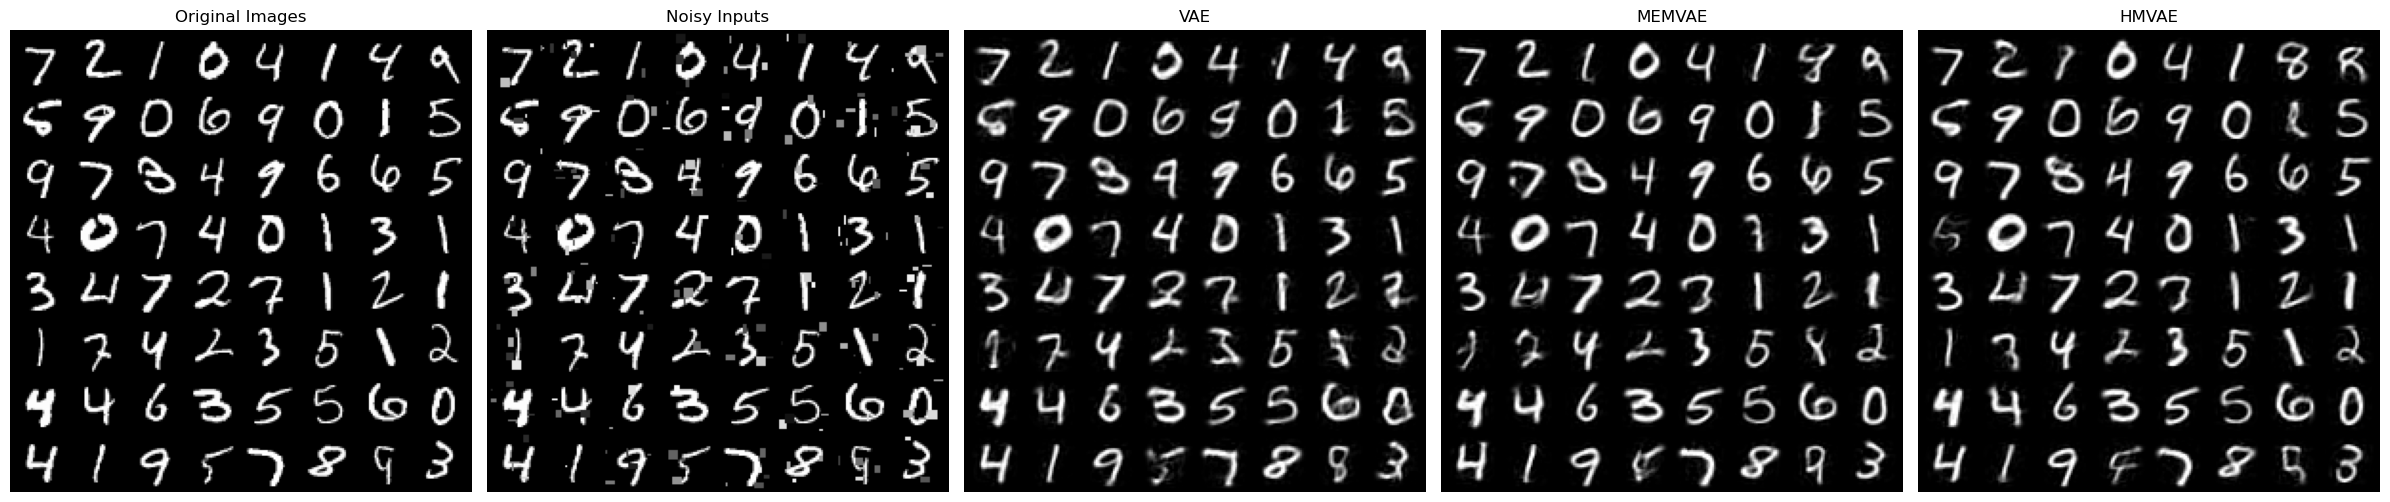

In [ ]:
def evaluate_generator_mse(model, test_loader, device, add_noise=True, 
                          max_num_masks=5, max_mask_ratio=0.2, save_samples=False):
   
   
    NORM_MEAN = 0.1307
    NORM_STD = 0.3081
    
    def normalize(tensor):
        return (tensor - NORM_MEAN) / NORM_STD
    
    def denormalize(tensor):
        return torch.clamp(tensor * NORM_STD + NORM_MEAN, 0.0, 1.0)

    model.eval()
    mse_loss = nn.MSELoss()
    mse_loss_none = nn.MSELoss(reduction='none')  
    total_psnr = 0.0
    total_mse = 0.0
    total_lpips = 0.0
    total_ssim = 0.0  
    total_samples = 0
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
           
            clean_images = denormalize(images.to(device))
            
            
            if add_noise:
                noisy_images = add_dynamic_mask_noise(clean_images, max_num_masks, max_mask_ratio)
                inputs = normalize(noisy_images)  
            else:
                inputs = normalize(clean_images)  

           
            gen_data, _ = model(inputs)
            gen_data = denormalize(gen_data) 
            gen_data = gen_data.view(-1, 1, 28, 28)
           
           
            batch_mse = mse_loss(gen_data, clean_images)
            batch_mse_per_sample = mse_loss_none(gen_data, clean_images)
            batch_mse_per_sample = batch_mse_per_sample.view(batch_mse_per_sample.shape[0], -1).mean(dim=1)
            batch_psnr = 10 * torch.log10(1.0 / (batch_mse_per_sample + 1e-10)).mean().item()
            
            clean_rgb = clean_images.repeat(1,3,1,1)  
            gen_rgb = gen_data.repeat(1,3,1,1)
            batch_lpips = loss_fn(clean_rgb, gen_rgb)
            
            
            batch_ssim = ssim(
                gen_data, 
                clean_images,
                data_range=1.0,  
                size_average=True  
            )
            
            total_psnr += batch_psnr * images.size(0)
            total_mse += batch_mse.item() * images.size(0)
            total_lpips += batch_lpips.sum().item()
            total_ssim += batch_ssim.item() * images.size(0)  
            total_samples += images.size(0)
            
            
            if save_samples and idx == 0:
                samples = (
                    clean_images[:64].cpu(),
                    inputs[:64].cpu(),
                    gen_data[:64].cpu()
                )
    
    avg_mse = total_mse / total_samples
    avg_lpips = total_lpips / total_samples
    avg_ssim = total_ssim / total_samples 
    avg_psnr = total_psnr / total_samples
    return avg_mse, avg_lpips, avg_ssim ,avg_psnr,samples
models = {
    "VAE": model_vae,
    "MEMVAE": model_MEMvae_1layers,
    "HMVAE": model_hmvae
}
samples_dict = {}
for model_name, model in models.items():
    mse,lpip,ssim_val, psnr_val,samples = evaluate_generator_mse(
        model, test_loader, device, 
        add_noise=True, save_samples=True
    )
    print(f"{model_name.ljust(15)} | MSE: {mse:.4f} | LPIPS: {lpip:.4f} | SSIM: {ssim_val:.4f} | PSNR: {psnr_val:.2f} dB")
    samples_dict[model_name] = (mse, samples)

plot_combined_comparison(
    samples_dict,
    save_dir="./dynamic_mask_noise_results",
    figsize=(24, 12)
)